# Data Preparation and Segmentation

## Introducción
Esta notebook se centra en la preparación y segmentación de los datos. La limpieza de los datos y la segmentación de productos según criterios específicos nos permitirán mejorar la precisión de los modelos de predicción.


## 1. Importación de Librerías

In [1]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## 2. Configuración del Entorno

In [2]:
# Configuración de opciones de pandas
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

# Configuración de estilo para las visualizaciones
sns.set(style="whitegrid")

# Configuración para reproducibilidad
np.random.seed(42)

data_dir = '../data/'
models_dir = '../models/'

## 3. Carga de Datos

In [225]:
# Cargar los datos desde archivos CSV
df = pd.read_excel(f'{data_dir}db_.xlsx', 'BBDD')

df.shape

(92212, 6)

In [10]:
df.head()

,date,expirationDate,paymentDate,sector,payerSalesSegment,amountFinanced
0,2020-11-05,2020-12-04,2020-11-29,Consumo Basico,6,1190000.0000
1,2020-11-05,2020-12-04,2020-11-15,Ganadería,6,120987.0000
2,2020-11-05,2020-12-04,2020-11-15,Ganadería,6,299285.0000
3,2020-11-05,2020-12-04,2020-11-29,Ganadería,6,1824520.0000
4,2020-11-05,2020-12-04,2020-11-15,Ganadería,6,89883.0000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92212 entries, 0 to 92211
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               92212 non-null  datetime64[ns]
 1   expirationDate     92212 non-null  datetime64[ns]
 2   paymentDate        84946 non-null  datetime64[ns]
 3   sector             90543 non-null  object        
 4   payerSalesSegment  92212 non-null  int64         
 5   amountFinanced     92210 non-null  float64       
dtypes: datetime64[ns](3), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


## 4. Reconstruccion historico

4.1. Manejo de Valores Nulos

In [227]:
## generar indice por factura
df_=df.sort_values("date").reset_index(drop=True).reset_index(names="id")
df_.head(2)

,id,date,expirationDate,paymentDate,sector,payerSalesSegment,amountFinanced
0,0,2020-11-05,2020-12-04,2020-11-29,Consumo Basico,6,1190000.0000
1,1,2020-11-05,2020-12-30,2020-12-28,Relacionados a Construccion,5,88155.0000


### Estructuracion

In [49]:
fecha_fin

Timestamp('2022-05-28 00:00:00')

In [177]:
## Reconstruccion de historial

fecha_fin = df_['date'].max()+ pd.offsets.MonthEnd(0)# llevar ultima fecha de corte
current_date = df_['date'].min().replace(day=1)

fecha_final = df_['date'].max()

# Generar todas las fechas de inicio y fin de mes en el rango
fechas_inicio = pd.date_range(start=current_date, end=fecha_fin, freq='MS')
fechas_fin = pd.date_range(start=current_date, end=fecha_fin, freq='ME')

# Almacenar resultados temporalmente en una lista
resultados = []

# Loop por cada rango mensual
for start_date, end_date in tqdm(zip(fechas_inicio, fechas_fin)):
    # Ajustar end_date si excede fecha_fin
    if end_date > fecha_final:
        end_date = fecha_final # fecha de ultima foto

    # Filtrar facturas activas del período anterior
    if len(resultados) > 0:
        # Concatenar resultados acumulados
        df_acumulado = pd.concat(resultados, ignore_index=True)
        
        # Obtener facturas activas en la fecha anterior
        fecha_corte_anterior = start_date - pd.Timedelta(days=1)
        df_status = df_[df_["id"].isin(
            df_acumulado[
                (df_acumulado["paymentDate"].isnull()) &
                (df_acumulado["fecha_corte"] == fecha_corte_anterior)
            ]['id'].unique()
        )].copy() 
        df_status["paymentDate"] = np.where(
            df_status["paymentDate"] > end_date, pd.NA, df_status["paymentDate"]
        )
        df_status.loc[:, "fecha_corte"] = end_date
        resultados.append(df_status)

    # Filtrar facturas creadas en el rango actual
    df_tmp_nuevo = df_[df_["date"].between(start_date, end_date)].copy() 
    df_tmp_nuevo["paymentDate"] = np.where(
        df_tmp_nuevo["paymentDate"] > end_date, pd.NA, df_tmp_nuevo["paymentDate"]
    )
    df_tmp_nuevo.loc[:, "fecha_corte"] = end_date
    resultados.append(df_tmp_nuevo)

# Combinar todos los resultados al final
df_result = pd.concat(resultados, ignore_index=True)

# Asegurar formatos de fecha
df_result['paymentDate'] = pd.to_datetime(df_result['paymentDate'])
df_result.head()

19it [00:00, 118.98it/s]


,id,date,expirationDate,paymentDate,sector,payerSalesSegment,amountFinanced,fecha_corte
0,0,2020-11-05,2020-12-04,2020-11-29,Consumo Basico,6,1190000.0000,2020-11-30
1,1,2020-11-05,2020-12-30,NaT,Relacionados a Construccion,5,88155.0000,2020-11-30
2,2,2020-11-05,2020-12-04,NaT,Ganadería,6,24060370.0000,2020-11-30
3,3,2020-11-05,2020-12-07,NaT,Telecomunicaciones,5,14085411.0000,2020-11-30
4,4,2020-11-05,2020-12-04,2020-11-29,Consumo Basico,6,1921788.0000,2020-11-30


In [178]:
df_result["fecha_corte"].min(),df_result["fecha_corte"].max()

(Timestamp('2020-11-30 00:00:00'), Timestamp('2022-05-28 00:00:00'))

In [181]:
## caso testigo 
df_[df_["paymentDate"]>(df_["date"]+pd.Timedelta(days=180))].head()

,id,date,expirationDate,paymentDate,sector,payerSalesSegment,amountFinanced
1784,1784,2020-11-21,2020-12-17,2021-06-13,Servicios de Salud,1,8710502.0000
3588,3588,2020-12-11,2021-01-25,2021-07-07,Comercio,2,6489369.0000
4202,4202,2020-12-17,2021-03-16,2021-06-30,Construcción Ingeniería e Infraestructura,5,2204032.0000
5864,5864,2021-01-04,2021-04-01,2021-12-10,Construcción de Viviendas,4,440824.0000
5865,5865,2021-01-04,2021-04-01,2021-12-10,Construcción de Viviendas,4,83033.0000


In [182]:
df_result['expirationDays'] = (df_result['expirationDate'] - df_result['date']).dt.days
df_result['paymentDays'] = np.where(df_result['paymentDate'].isnull(),(df_result['fecha_corte'] - df_result['expirationDate']).dt.days, # fecha de corte "foto"
                             (df_result['paymentDate'] - df_result['expirationDate']).dt.days)

df_result.head()


,id,date,expirationDate,paymentDate,sector,payerSalesSegment,amountFinanced,fecha_corte,expirationDays,paymentDays
0,0,2020-11-05,2020-12-04,2020-11-29,Consumo Basico,6,1190000.0000,2020-11-30,29,-5.0000
1,1,2020-11-05,2020-12-30,NaT,Relacionados a Construccion,5,88155.0000,2020-11-30,55,-30.0000
2,2,2020-11-05,2020-12-04,NaT,Ganadería,6,24060370.0000,2020-11-30,29,-4.0000
3,3,2020-11-05,2020-12-07,NaT,Telecomunicaciones,5,14085411.0000,2020-11-30,32,-7.0000
4,4,2020-11-05,2020-12-04,2020-11-29,Consumo Basico,6,1921788.0000,2020-11-30,29,-5.0000


In [12]:
df_result[df_result["id"]==1784]

,id,date,expirationDate,paymentDate,sector,payerSalesSegment,amountFinanced,fecha_corte,expirationDays,paymentDays
1784,1784,2020-11-21,2020-12-17,NaT,Servicios de Salud,1,8710502.0000,2020-11-30,26,-17.0000
4215,1784,2020-11-21,2020-12-17,NaT,Servicios de Salud,1,8710502.0000,2020-12-31,26,14.0000
8590,1784,2020-11-21,2020-12-17,NaT,Servicios de Salud,1,8710502.0000,2021-01-31,26,45.0000
16644,1784,2020-11-21,2020-12-17,NaT,Servicios de Salud,1,8710502.0000,2021-02-28,26,73.0000
26110,1784,2020-11-21,2020-12-17,NaT,Servicios de Salud,1,8710502.0000,2021-03-31,26,104.0000
36197,1784,2020-11-21,2020-12-17,NaT,Servicios de Salud,1,8710502.0000,2021-04-30,26,134.0000
45944,1784,2020-11-21,2020-12-17,NaT,Servicios de Salud,1,8710502.0000,2021-05-31,26,165.0000
57311,1784,2020-11-21,2020-12-17,2021-06-13,Servicios de Salud,1,8710502.0000,2021-06-30,26,178.0000


In [183]:
# guardo base
df_result.to_parquet(f'{data_dir}complete_data.parquet')

## 5. VD

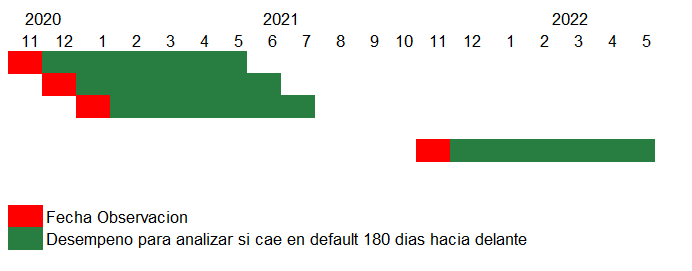

In [184]:
complete_data=pd.read_parquet(f'{data_dir}complete_data.parquet')
print(complete_data.shape)

complete_data.head()


(223983, 10)


,id,date,expirationDate,paymentDate,sector,payerSalesSegment,amountFinanced,fecha_corte,expirationDays,paymentDays
0,0,2020-11-05,2020-12-04,2020-11-29,Consumo Basico,6,1190000.0000,2020-11-30,29,-5.0000
1,1,2020-11-05,2020-12-30,NaT,Relacionados a Construccion,5,88155.0000,2020-11-30,55,-30.0000
2,2,2020-11-05,2020-12-04,NaT,Ganadería,6,24060370.0000,2020-11-30,29,-4.0000
3,3,2020-11-05,2020-12-07,NaT,Telecomunicaciones,5,14085411.0000,2020-11-30,32,-7.0000
4,4,2020-11-05,2020-12-04,2020-11-29,Consumo Basico,6,1921788.0000,2020-11-30,29,-5.0000


In [197]:
df_id=complete_data[["id","fecha_corte","paymentDays",'expirationDate','paymentDate']].copy()
df_id.head()


,id,fecha_corte,paymentDays,expirationDate,paymentDate
0,0,2020-11-30,-5.0000,2020-12-04,2020-11-29
1,1,2020-11-30,-30.0000,2020-12-30,NaT
2,2,2020-11-30,-4.0000,2020-12-04,NaT
3,3,2020-11-30,-7.0000,2020-12-07,NaT
4,4,2020-11-30,-5.0000,2020-12-04,2020-11-29


In [198]:
df_id["fecha_default"]=(df_id["expirationDate"]+pd.Timedelta(days=180))+pd.offsets.MonthEnd(0)

df_id["fecha_default"]=np.where(df_id["fecha_corte"]>df_id["fecha_default"],df_id["fecha_corte"],df_id["fecha_default"])
df_id.head()

,id,fecha_corte,paymentDays,expirationDate,paymentDate,fecha_default
0,0,2020-11-30,-5.0000,2020-12-04,2020-11-29,2021-06-30
1,1,2020-11-30,-30.0000,2020-12-30,NaT,2021-06-30
2,2,2020-11-30,-4.0000,2020-12-04,NaT,2021-06-30
3,3,2020-11-30,-7.0000,2020-12-07,NaT,2021-06-30
4,4,2020-11-30,-5.0000,2020-12-04,2020-11-29,2021-06-30


In [187]:
df_id[df_id["id"]==5493]

,id,fecha_corte,paymentDays,expirationDate,fecha_default
7920,5493,2020-12-31,-97.0000,2021-04-07,2021-10-31
11545,5493,2021-01-31,-66.0000,2021-04-07,2021-10-31
18074,5493,2021-02-28,-38.0000,2021-04-07,2021-10-31
27013,5493,2021-03-31,-7.0000,2021-04-07,2021-10-31
36427,5493,2021-04-30,23.0000,2021-04-07,2021-10-31
46011,5493,2021-05-31,54.0000,2021-04-07,2021-10-31
57329,5493,2021-06-30,84.0000,2021-04-07,2021-10-31
69659,5493,2021-07-31,115.0000,2021-04-07,2021-10-31
83570,5493,2021-08-31,146.0000,2021-04-07,2021-10-31
97968,5493,2021-09-30,176.0000,2021-04-07,2021-10-31


In [219]:
import pandasql as psql

# Definir la consulta SQL ajustada
query = """
WITH merged_data AS (SELECT 
    a.id, 
    DATE(a.fecha_corte) as fecha_observacion,
    DATE(a.expirationDate) expirationDate,
    DATE(a.paymentDate) paymentDate,
    case when b.paymentDate is null then 0 else 1 end as pago,
    DATE(DATE(a.expirationDate, '+6 months'), 'start of month', '+1 month', '-1 day') expirationDate_180 ,
    case when a.fecha_corte=b.fecha_corte then b.paymentDays else 0 end m_dven_0,
    b.fecha_corte,
    b.paymentDays
FROM 
    df_id a
inner JOIN 
    df_id b
ON a.id = b.id 
    AND a.fecha_corte <= b.fecha_corte 
    AND b.fecha_corte <= a.fecha_default ),
tabla as (
select  
id,
fecha_observacion,
expirationDate,
paymentDate,
expirationDate_180,
max(pago) pago, 
max(m_dven_0) m_dven_0, 
max(paymentDays) m_dven
from  merged_data
group by id,fecha_observacion,expirationDate,expirationDate_180,paymentDate)
select * from tabla 
"""

# Ejecutar la consulta SQL con pandasql
df_vd = psql.sqldf(query, locals())

print(df_vd.shape)

df_vd.head()

(223983, 8)


,id,fecha_observacion,expirationDate,paymentDate,expirationDate_180,pago,m_dven_0,m_dven
0,0,2020-11-30,2020-12-04,2020-11-29,2021-06-30,1,-5.0000,-5.0000
1,1,2020-11-30,2020-12-30,None,2021-06-30,1,0.0000,-2.0000
2,1,2020-12-31,2020-12-30,2020-12-28,2021-06-30,1,-2.0000,-2.0000
3,2,2020-11-30,2020-12-04,None,2021-06-30,1,0.0000,0.0000
4,2,2020-12-31,2020-12-04,2020-12-04,2021-06-30,1,0.0000,0.0000


In [201]:
df_vd["expirationDate_180"].max(),df_vd["fecha_observacion"].max()

('2023-04-30', '2022-05-28')

In [220]:
df_vd["vd"]= np.where(df_vd["m_dven_0"]>=180,2, # malo observado
            np.where(df_vd["m_dven"]>=180,1, # cae en default
                     0))

df_vd["vd"]= np.where((df_vd["expirationDate_180"]>="2022-05-28")&(df_vd["pago"]==0)
                      ,4, # sin informacion
            df_vd["vd"])

In [230]:
df_vd[df_vd['vd']==4].sort_values("fecha_observacion").head()

,id,fecha_observacion,expirationDate,paymentDate,expirationDate_180,pago,m_dven_0,m_dven,vd
94756,36136,2021-07-31,2022-01-24,None,2022-07-31,0,0.0000,124.0000,4
100235,37971,2021-07-31,2021-11-29,None,2022-05-31,0,0.0000,180.0000,4
100680,38127,2021-07-31,2022-01-24,None,2022-07-31,0,0.0000,124.0000,4
100691,38128,2021-07-31,2022-01-24,None,2022-07-31,0,0.0000,124.0000,4
100796,38166,2021-07-31,2021-10-31,None,2022-05-31,0,0.0000,181.0000,4


In [233]:
df_vd[df_vd['id']==36136]

,id,fecha_observacion,expirationDate,paymentDate,expirationDate_180,pago,m_dven_0,m_dven,vd
94756,36136,2021-07-31,2022-01-24,None,2022-07-31,0,0.0000,124.0000,4
94757,36136,2021-08-31,2022-01-24,None,2022-07-31,0,0.0000,124.0000,4
94758,36136,2021-09-30,2022-01-24,None,2022-07-31,0,0.0000,124.0000,4
94759,36136,2021-10-31,2022-01-24,None,2022-07-31,0,0.0000,124.0000,4
94760,36136,2021-11-30,2022-01-24,None,2022-07-31,0,0.0000,124.0000,4
94761,36136,2021-12-31,2022-01-24,None,2022-07-31,0,0.0000,124.0000,4
94762,36136,2022-01-31,2022-01-24,None,2022-07-31,0,7.0000,124.0000,4
94763,36136,2022-02-28,2022-01-24,None,2022-07-31,0,35.0000,124.0000,4
94764,36136,2022-03-31,2022-01-24,None,2022-07-31,0,66.0000,124.0000,4
94765,36136,2022-04-30,2022-01-24,None,2022-07-31,0,96.0000,124.0000,4


In [234]:
# Poblacion
df_resumen=df_vd.pivot_table(
    columns='vd',
    index='fecha_observacion',
    aggfunc='size',
    fill_value=0
)
df_resumen["bad_rate"]=df_resumen[1]/(df_resumen[0]+df_resumen[1])
df_resumen

vd,0,1,2,4,bad_rate
fecha_observacion,,,,,
2020-11-30,2835,0,0,0,0.0000
2020-12-31,5137,14,0,0,0.0027
2021-01-31,8341,32,0,0,0.0038
2021-02-28,9623,50,0,0,0.0052
2021-03-31,10056,95,0,0,0.0094
2021-04-30,9626,135,0,0,0.0138
2021-05-31,11160,207,0,0,0.0182
2021-06-30,12025,309,0,0,0.0251
2021-07-31,13405,497,1,9,0.0358


In [ ]:
# Analizando los datos se podria tener como ultima fecha de observacion 2021-12-31 
# y dejar el mes completo 2022-01-31 para probar el modelo con la base completa


In [235]:
# para esta poblacion tengo registros duplicados, es decir si un sujeto no paga va aparecer tantas veces hasta que se pague o quede como malo observad
# hay diferentes metodologia de extraer una muestra para que los registros sea linealmente independientes 
# Si una factura se repite varias veces voy extraer una muestra aleatoria de tal forma que el registro quede solo en un perido


In [253]:
df_vd[df_vd["fecha_observacion"]<="2021-12-31"].head()

,id,fecha_observacion,expirationDate,paymentDate,expirationDate_180,pago,m_dven_0,m_dven,vd
0,0,2020-11-30,2020-12-04,2020-11-29,2021-06-30,1,-5.0000,-5.0000,0
1,1,2020-11-30,2020-12-30,None,2021-06-30,1,0.0000,-2.0000,0
2,1,2020-12-31,2020-12-30,2020-12-28,2021-06-30,1,-2.0000,-2.0000,0
3,2,2020-11-30,2020-12-04,None,2021-06-30,1,0.0000,0.0000,0
4,2,2020-12-31,2020-12-04,2020-12-04,2021-06-30,1,0.0000,0.0000,0


In [ ]:
df_result.to_parquet(f'{data_dir}complete_data.parquet')


In [255]:
df_vd[["id","fecha_observacion","vd"]].to_parquet(f'{data_dir}complete_data_vd.parquet')

In [243]:
df_muestra=df_vd[df_vd["fecha_observacion"]<="2021-12-31"].groupby(['id']).sample(n=1)
df_muestra.shape,df_vd.shape

((68911, 9), (223983, 9))

In [246]:
df_muestra.head()

,id,fecha_observacion,expirationDate,paymentDate,expirationDate_180,pago,m_dven_0,m_dven,vd
0,0,2020-11-30,2020-12-04,2020-11-29,2021-06-30,1,-5.0000,-5.0000,0
1,1,2020-11-30,2020-12-30,None,2021-06-30,1,0.0000,-2.0000,0
4,2,2020-12-31,2020-12-04,2020-12-04,2021-06-30,1,0.0000,0.0000,0
5,3,2020-11-30,2020-12-07,None,2021-06-30,1,0.0000,0.0000,0
7,4,2020-11-30,2020-12-04,2020-11-29,2021-06-30,1,-5.0000,-5.0000,0


In [245]:
# Poblacion
df_resumen=df_vd[df_vd["fecha_observacion"]<="2021-12-31"].pivot_table(
    columns='vd',
    index='fecha_observacion',
    aggfunc='size',
    fill_value=0
)
df_resumen["bad_rate"]=df_resumen[1]/(df_resumen[0]+df_resumen[1])
df_resumen

vd,0,1,2,4,bad_rate
fecha_observacion,,,,,
2020-11-30,2835,0,0,0,0.0000
2020-12-31,5137,14,0,0,0.0027
2021-01-31,8341,32,0,0,0.0038
2021-02-28,9623,50,0,0,0.0052
2021-03-31,10056,95,0,0,0.0094
2021-04-30,9626,135,0,0,0.0138
2021-05-31,11160,207,0,0,0.0182
2021-06-30,12025,309,0,0,0.0251
2021-07-31,13405,497,1,9,0.0358


In [250]:
df_vd[df_vd["fecha_observacion"]<="2021-12-31"]['fecha_observacion'].value_counts(1).sort_index()

fecha_observacion
2020-11-30   0.0176
2020-12-31   0.0319
2021-01-31   0.0519
2021-02-28   0.0600
2021-03-31   0.0629
2021-04-30   0.0605
2021-05-31   0.0705
2021-06-30   0.0765
2021-07-31   0.0863
2021-08-31   0.0893
2021-09-30   0.0886
2021-10-31   0.1098
2021-11-30   0.1002
2021-12-31   0.0940
Name: proportion, dtype: float64

In [244]:
# Poblacion
df_resumen=df_muestra.pivot_table(
    columns='vd',
    index='fecha_observacion',
    aggfunc='size',
    fill_value=0
)
df_resumen["bad_rate"]=df_resumen[1]/(df_resumen[0]+df_resumen[1])
df_resumen

vd,0,1,2,4,bad_rate
fecha_observacion,,,,,
2020-11-30,1422,0,0,0,0.0000
2020-12-31,2131,0,0,0,0.0000
2021-01-31,3337,1,0,0,0.0003
2021-02-28,3993,6,0,0,0.0015
2021-03-31,4072,5,0,0,0.0012
2021-04-30,3933,14,0,0,0.0035
2021-05-31,4752,25,0,0,0.0052
2021-06-30,4958,36,0,0,0.0072
2021-07-31,5426,80,0,2,0.0145


In [27]:
df_vd[df_vd["comportamiento"]==7]

,id,fecha_observacion,comportamiento,m_dven
4146,1784,2020-12-31 00:00:00.000000,7,178.0000
8740,3588,2020-12-31 00:00:00.000000,7,156.0000
8946,3668,2020-12-31 00:00:00.000000,7,75.0000
8949,3668,2021-03-31 00:00:00.000000,7,167.0000
8951,3668,2021-05-31 00:00:00.000000,7,228.0000
...,...,...,...,...
150600,57633,2021-10-31 00:00:00.000000,7,149.0000
150607,57634,2021-10-31 00:00:00.000000,7,149.0000
150616,57636,2021-10-31 00:00:00.000000,7,149.0000
150659,57655,2021-10-31 00:00:00.000000,7,142.0000
